# Exploring some of the classified SN light-curves

In [1]:
import sys
import glob,os
import numpy as np
import pandas as pd
from pathlib import Path
from matplotlib import pyplot as plt
sys.path.append("../")
import utils.data_utils as du
import utils.visualization_utils as vu

/Users/anaismoller/miniconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# Init paths
raw_dir = os.environ.get("DES_DATA")
debug=False

## Load predictions
e.g. vanilla RNN and inspect photometrically classified sample and those events that are lost

In [3]:
# model
model_name = "vanilla_S_0_CLF_2_R_None_photometry_DF_1.0_N_global_lstm_32x2_0.05_128_True_mean_C"
# load predictions 
df_pred = {}
for dtype in ["fake", "real"]:   
    pred_dir = f'../dumps/{dtype}/clump/models/'
    pred_file = f'{pred_dir}/{model_name}/PRED_{model_name}.pickle'
    df_pred[dtype] = pd.read_pickle(pred_file)

### Selecting SNe for inspection
e.g. lets find those spectroscopic Ias that are not photometrically classified as Ias. 

In [44]:
# We set probability of classification 0.5 as threshold
# remember class0=prob of being Ia
for dtype in ["fake", "real"]:   
    df_pred[dtype]["predicted_target"] = (
        df_pred[dtype][[k for k in df_pred[dtype].keys() if "all_class" in k]]
        .idxmax(axis=1)
        .str.strip("all_class")
        .astype(int))
    clump_file = f"{Path(raw_dir)}/DESALL_forcePhoto_{dtype}_snana_fits/DESALL_{dtype}_clump.SNANA.TEXT"
    if Path(clump_file).exists():
        df_clump = du.load_fits(clump_file)
        df_clump['PKMJD_clump'] = df_clump['PKMJDINI']
        df_clump = df_clump[['SNID','PKMJD_clump']]
        df_pred[dtype] = df_pred[dtype].merge(df_clump, on ="SNID")
    bazin_file = f"{Path(raw_dir)}/DESALL_forcePhoto_{dtype}_snana_fits/DESALL_{dtype}_Bazin_fit.SNANA.TEXT"
    if Path(bazin_file).exists():
        df_bazin = du.load_fits(bazin_file)
        df_bazin = df_bazin[['SNID']+[k for k in df_bazin.keys() if k not in df_pred[dtype].keys()]]
        df_pred[dtype] = df_pred[dtype].merge(df_bazin, on ="SNID")

In [45]:
def get_photo_sample_w_spec_tags(df_pred, photo_SNIDs=None):

    # define photo samples
    photo_Ia = {}
    photo_nonIa = {}

    photo_tmp = df_pred[df_pred['predicted_target'] == 0].copy()

    if photo_SNIDs:
        photo_Ia['all'] = photo_tmp[photo_tmp['SNID'].isin(photo_SNIDs)]
    else:
        photo_Ia['all'] = photo_tmp
        photo_SNIDs = photo_tmp.SNID.values
        
    photo_nonIa['all'] = df_pred[~df_pred['SNID'].isin(photo_SNIDs)].copy()

    photo_Ia['spec_Ia'] = photo_Ia['all'][(
        photo_Ia['all']['TYPE'] == 1) | (photo_Ia['all']['TYPE'] == 101)]
    
    photo_Ia['spec_nonIa'] = photo_Ia['all'][(photo_Ia['all']['TYPE'] != 0) & (
        photo_Ia['all']['TYPE'] != 1) & (photo_Ia['all']['TYPE'] != 101)]
    photo_Ia['all_no_spec_nonIa'] = photo_Ia['all'][(photo_Ia['all']['TYPE'] == 0) | (
        photo_Ia['all']['TYPE'] == 1) | (photo_Ia['all']['TYPE'] == 101)]

    photo_nonIa['spec_Ia'] = photo_nonIa['all'][(photo_nonIa['all']['TYPE'] == 1) | (photo_nonIa['all']['TYPE'] == 101)]
    photo_nonIa['spec_nonIa'] = photo_nonIa['all'][(photo_nonIa['all']['TYPE'] != 0) & (
        photo_nonIa['all']['TYPE'] != 1) & (photo_nonIa['all']['TYPE'] != 101)]

    return photo_Ia, photo_nonIa

In [46]:
photo_Ia, photo_nonIa = get_photo_sample_w_spec_tags(
            df_pred['real'])

In [26]:
# now lets see which SNe (IDs) are spec Ias but not classified as Ias
ids_lost_spec_Ia = [i for i in photo_nonIa['spec_Ia'].SNID.values]

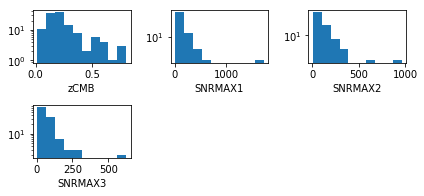

In [32]:
# General properties
list_var = ["zCMB",'SNRMAX1', 'SNRMAX2','SNRMAX3']
fig = plt.figure()
for i,var in enumerate(list_var):
    ax=plt.subplot(3,3,i+1)
    ax.hist(photo_nonIa['spec_Ia'][var])
    ax.set_yscale("log")
    ax.set_xlabel(var)
fig.tight_layout()
fig.subplots_adjust(top=0.88)

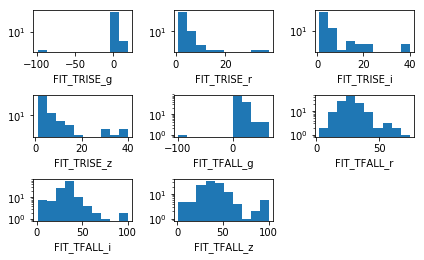

In [47]:
# bazin fit properties
list_var = ['FIT_TRISE_g', 'FIT_TRISE_r', 'FIT_TRISE_i', 'FIT_TRISE_z',
       'FIT_TFALL_g', 'FIT_TFALL_r', 'FIT_TFALL_i', 'FIT_TFALL_z']
fig = plt.figure()
for i,var in enumerate(list_var):
    ax=plt.subplot(3,3,i+1)
    ax.hist(photo_nonIa['spec_Ia'][var])
    ax.set_yscale("log")
    ax.set_xlabel(var)
fig.tight_layout()
fig.subplots_adjust(top=0.88)

# Inspecting using SNN
this allows us to look at exactly the photometry that SNN uses instead of yearly stacks

In [48]:
model_files = [
    f"../SuperNNova_general/trained_models_mutant/{model_name}/{model_name}.pt"]
skim_dir = f"./dumps/real/clump/"
out_dir = '../dumps/spec_Ia_classified_as_nonIa_SNN/'

In [59]:
# for a reason, SuperNNova modules dont work properly with ipython so need to run this separetely
# see inspect_photo_samples to see how it is done
# vu.plot_early_classification(skim_dir, prefix='test_', df=photo_Ia['all'], model_files=model_files, out_dir=out_dir)

## Inspect using photometry from yearly stacks
very slow, need to optimize if this is going to be done usually

In [24]:
# load fits files
df_fits = {}
for dtype in ["fake", "real"]:
    # load fits files and merge them in one
    bazin_file = f"{Path(raw_dir)}/DESALL_forcePhoto_{dtype}_snana_fits/DESALL_{dtype}_Bazin_fit.SNANA.TEXT"
    clump_file = f"{Path(raw_dir)}/DESALL_forcePhoto_{dtype}_snana_fits/DESALL_{dtype}_clump.SNANA.TEXT"
    if Path(bazin_file).exists():
        df_bazin = du.load_fits(bazin_file)
    if Path(clump_file).exists():
        df_clump = du.load_fits(clump_file)
    df_clump['PKMJD_clump'] = df_clump['PKMJDINI']
    df_fits[dtype] = df_clump[['SNID','PKMJD_clump']]
    df_fits[dtype] = df_fits[dtype].merge(df_bazin,on='SNID')
    df_fits[dtype] = df_fits[dtype][['SNID', 'PKMJD_clump','TYPE', 
       'CUTFLAG_SNANA', 'zCMB', 'zCMBERR', 'zHD', 'zHDERR',
       'VPEC', 'VPECERR', 'HOST_LOGMASS', 'HOST_LOGMASS_ERR', 'HOST_sSFR',
       'HOST_sSFR_ERR', 'PKMJDINI', 'FIT_T0_g', 'FIT_T0_r', 'FIT_T0_i',
       'FIT_T0_z', 'FIT_TRISE_g', 'FIT_TRISE_r', 'FIT_TRISE_i', 'FIT_TRISE_z',
       'FIT_TFALL_g', 'FIT_TFALL_r', 'FIT_TFALL_i', 'FIT_TFALL_z', 'FIT_A0_g',
       'FIT_A0_r', 'FIT_A0_i', 'FIT_A0_z', 'FIT_A1_g', 'FIT_A1_r', 'FIT_A1_i',
       'FIT_A1_z', 'FIT_A2_g', 'FIT_A2_r', 'FIT_A2_i', 'FIT_A2_z',
       'PKMJD_FIT_g', 'PKMJD_ERR_g', 'PKMJD_FIT_r', 'PKMJD_ERR_r',
       'PKMJD_FIT_i', 'PKMJD_ERR_i', 'PKMJD_FIT_z', 'PKMJD_ERR_z',
       'FIT_CHI2_g', 'FIT_CHI2_r', 'FIT_CHI2_i', 'FIT_CHI2_z', 'FIT_NDOF_g',
       'FIT_NDOF_r', 'FIT_NDOF_i', 'FIT_NDOF_z', 'SNRMAX1', 'SNRMAX2',
       'SNRMAX3']]

In [ ]:
# load complete data
# BEWARE! this is the complete yearly stack, if you want to look at the SNN light-curves use the SNN module!
df = {} # only header
df_w_photo = {} # merged with photometry

#load photometry and header fits tables
# horrible way of doing this! but it is to play with the data

for dtype in ["fake", "real"]:    
    list_files = glob.glob(os.path.join(f"{raw_dir}/DESALL_forcePhoto_{dtype}_snana_fits/", "*PHOT.FITS"))
    df_head_tmp = []
    df_head_w_phot_tmp = []
    
    for fname in list_files:
        df_header, df_phot = du.read_fits(fname)
        df_header = pd.merge(df_header, df_fits[dtype], on='SNID')
        df_header = df_header[[
            k for k in df_header.keys() if 'Unnamed' not in k]]
        df_head_tmp.append(df_header)
        df_head_w_phot_tmp.append(df_header.merge(df_phot,on='SNID'))
        
    df[dtype] = pd.concat(df_head_tmp)
    df_w_photo[dtype] = pd.concat(df_head_w_phot_tmp)

In [ ]:
# now lets plot some of these random lcs
df_sel_w_photo = df_w_photo["real"][df_w_photo["real"].SNID.isin(ids_lost_spec_Ia)]
# this will save the plots as well
vu.plot_random_lcs(df_sel_w_photo, f'../dumps/real/clump/lightcurves/{model_name}/spec_Ia_classified_as_nonIa_yearly_stack/', multiplots=False, nb_lcs=10, plot_peak=False)